In [43]:
#Importation des packages
!pip install openpyxl
!pip install -U kaleido
!pip install statsmodels

import kaleido
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt 
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import minimize

In [44]:
legi24T1 = pd.read_excel('data/LEGI24T1.xlsx', engine='openpyxl')
legi24T2 = pd.read_excel('data/LEGI24T2.xlsx', engine='openpyxl')
euro24 = pd.read_excel('data/EURO24.xlsx')

In [45]:
liste_communes_circo1 = ['95014', '95197', '95210', '95369', '95427', '95555', '95582', '95598']

legi24T1['Code commune'] = legi24T1['Code commune'].astype(str, errors='ignore')
legi24T1_95C6= legi24T1[legi24T1['Code commune'].isin(liste_communes_circo1)]

legi24T2['Code commune'] = legi24T2['Code commune'].astype(str, errors='ignore')
legi24T2_95C6 = legi24T2[legi24T2['Code commune'].isin(liste_communes_circo1)]

euro24['Code commune'] = euro24['Code commune'].astype(str, errors='ignore')
euro24_95C6 = euro24[euro24['Code commune'].isin(liste_communes_circo1)]

euro_drop=['Code localisation', 'Libellé localisation', 'Code département', 'Libellé département', 'Libellé commune'] 
num_drop = [f'Numéro de panneau {i}' for i in range(1, 39)] 
libab_drop = [f'Libellé abrégé de liste {i}' for i in range(1, 39)] 
lib_drop = [f'Libellé de liste {i}' for i in range(1, 39)] 
siege_drop = [f'Sièges {i}' for i in range(1, 39)] 

euro_drop = euro_drop + num_drop + libab_drop + lib_drop + siege_drop

euro24_C6_clean = euro24_95C6.drop(columns=euro_drop)

def is_percentage(val):
    return isinstance(val, str) and '%' in val

def convert_percentage(val):
    if is_percentage(val):
        return float(val.replace(',', '.').replace('%', '')) / 100
    return val 

# Convertir toutes les colonnes de pourcentages en valeurs numériques
df_numeric = euro24_C6_clean.map(convert_percentage)

numeric_cols = df_numeric.select_dtypes(include='number')

# Identifier les colonnes à exclure (où toutes les valeurs sont < 0,01)
cols_to_drop = numeric_cols.columns[(numeric_cols < 0.015).all()]
cols_to_drop

Index(['% Blancs/inscrits', '% Nuls/inscrits', 'Voix 1', '% Voix/inscrits 1',
       '% Voix/exprimés 1', '% Voix/inscrits 2', '% Voix/exprimés 2', 'Voix 9',
       '% Voix/inscrits 9', '% Voix/exprimés 9', '% Voix/inscrits 10',
       '% Voix/inscrits 12', '% Voix/inscrits 13', '% Voix/exprimés 13',
       '% Voix/inscrits 14', '% Voix/inscrits 16', '% Voix/exprimés 16',
       '% Voix/inscrits 17', '% Voix/exprimés 17', '% Voix/inscrits 19',
       '% Voix/inscrits 20', '% Voix/exprimés 20', '% Voix/inscrits 21',
       '% Voix/exprimés 21', '% Voix/inscrits 22', '% Voix/exprimés 22',
       '% Voix/inscrits 23', '% Voix/exprimés 23', '% Voix/inscrits 24',
       '% Voix/inscrits 25', '% Voix/exprimés 25', '% Voix/inscrits 26',
       '% Voix/exprimés 26', '% Voix/inscrits 28', '% Voix/exprimés 28',
       '% Voix/inscrits 29', '% Voix/inscrits 30', '% Voix/exprimés 30',
       '% Voix/inscrits 31', '% Voix/exprimés 31', '% Voix/inscrits 32',
       '% Voix/exprimés 32', '% Voix/insc

In [46]:
cols_to_drop = ['Nuance liste 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1', 'Nuance liste 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2',  
                '% Voix/inscrits 9', '% Voix/exprimés 9', 'Nuance liste 9', 'Voix 9', '% Voix/inscrits 13', '% Voix/exprimés 13', 'Nuance liste 13', 'Voix 13', 
       '% Voix/inscrits 16', '% Voix/exprimés 16', 'Nuance liste 16', 'Voix 16', '% Voix/inscrits 17', '% Voix/exprimés 17', 'Nuance liste 17', 'Voix 17', 
                '% Voix/inscrits 20', '% Voix/exprimés 20', 'Nuance liste 20', 'Voix 20', 
       '% Voix/inscrits 21', '% Voix/exprimés 21', 'Nuance liste 21', 'Voix 21', '% Voix/inscrits 22',
       '% Voix/exprimés 22', 'Nuance liste 22', 'Voix 22', '% Voix/inscrits 23', '% Voix/exprimés 23', 'Nuance liste 23', 'Voix 23', '% Voix/inscrits 25', '% Voix/exprimés 25',
                'Nuance liste 25', 'Voix 25', '% Voix/inscrits 26', '% Voix/exprimés 26', 'Nuance liste 26', 'Voix 26', '% Voix/inscrits 28',
       '% Voix/exprimés 28', 'Nuance liste 28', 'Voix 28', '% Voix/inscrits 29', '% Voix/exprimés 29', 'Nuance liste 29', 'Voix 29',
       '% Voix/inscrits 30', '% Voix/exprimés 30', 'Nuance liste 30', 'Voix 30', '% Voix/inscrits 31',
       '% Voix/exprimés 31', 'Nuance liste 31', 'Voix 31', '% Voix/inscrits 32', '% Voix/exprimés 32', 'Nuance liste 32', 'Voix 32',
       '% Voix/inscrits 34', '% Voix/exprimés 34', 'Nuance liste 34', 'Voix 34', '% Voix/inscrits 36', '% Voix/exprimés 36', 'Nuance liste 36', 'Voix 36', '% Voix/inscrits 37',
       '% Voix/exprimés 37', 'Nuance liste 37', 'Voix 37', '% Voix/inscrits 38', '% Voix/exprimés 38', 'Nuance liste 38', 'Voix 38' ]

euro24_C6_clean = euro24_C6_clean.drop(columns=cols_to_drop)
euro24_C6_clean

,Code commune,Code BV,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,% Exprimés/inscrits,% Exprimés/votants,...,% Voix/inscrits 27,% Voix/exprimés 27,Nuance liste 33,Voix 33,% Voix/inscrits 33,% Voix/exprimés 33,Nuance liste 35,Voix 35,% Voix/inscrits 35,% Voix/exprimés 35
66456,95014,0001,710,386,"54,37%",324,"45,63%",377,"53,10%","97,67%",...,"6,06%","11,41%",LCOM,7,"0,99%","1,86%",LECO,2,"0,28%","0,53%"
66457,95014,0002,805,473,"58,76%",332,"41,24%",470,"58,39%","99,37%",...,"7,95%","13,62%",LCOM,4,"0,50%","0,85%",LECO,9,"1,12%","1,91%"
66668,95197,0001,1006,520,"51,69%",486,"48,31%",512,"50,89%","98,46%",...,"6,46%","12,70%",LCOM,11,"1,09%","2,15%",LECO,3,"0,30%","0,59%"
66669,95197,0002,930,564,"60,65%",366,"39,35%",554,"59,57%","98,23%",...,"9,25%","15,52%",LCOM,3,"0,32%","0,54%",LECO,6,"0,65%","1,08%"
66670,95197,0003,905,405,"44,75%",500,"55,25%",397,"43,87%","98,02%",...,"5,30%","12,09%",LCOM,3,"0,33%","0,76%",LECO,3,"0,33%","0,76%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67204,95598,0006,1265,769,"60,79%",496,"39,21%",757,"59,84%","98,44%",...,"7,04%","11,76%",LCOM,6,"0,47%","0,79%",LECO,11,"0,87%","1,45%"
67205,95598,0007,1070,547,"51,12%",523,"48,88%",541,"50,56%","98,90%",...,"8,69%","17,19%",LCOM,5,"0,47%","0,92%",LECO,7,"0,65%","1,29%"
67206,95598,0008,1003,410,"40,88%",593,"59,12%",397,"39,58%","96,83%",...,"4,59%","11,59%",LCOM,10,"1,00%","2,52%",LECO,5,"0,50%","1,26%"
67207,95598,0009,1298,587,"45,22%",711,"54,78%",576,"44,38%","98,13%",...,"5,16%","11,63%",LCOM,8,"0,62%","1,39%",LECO,5,"0,39%","0,87%"


In [47]:
euro24_C6_clean.columns

Index(['Code commune', 'Code BV', 'Inscrits', 'Votants', '% Votants',
       'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits',
       '% Exprimés/votants', 'Blancs', '% Blancs/inscrits', '% Blancs/votants',
       'Nuls', '% Nuls/inscrits', '% Nuls/votants', 'Nuance liste 3', 'Voix 3',
       '% Voix/inscrits 3', '% Voix/exprimés 3', 'Nuance liste 4', 'Voix 4',
       '% Voix/inscrits 4', '% Voix/exprimés 4', 'Nuance liste 5', 'Voix 5',
       '% Voix/inscrits 5', '% Voix/exprimés 5', 'Nuance liste 6', 'Voix 6',
       '% Voix/inscrits 6', '% Voix/exprimés 6', 'Nuance liste 7', 'Voix 7',
       '% Voix/inscrits 7', '% Voix/exprimés 7', 'Nuance liste 8', 'Voix 8',
       '% Voix/inscrits 8', '% Voix/exprimés 8', 'Nuance liste 10', 'Voix 10',
       '% Voix/inscrits 10', '% Voix/exprimés 10', 'Nuance liste 11',
       'Voix 11', '% Voix/inscrits 11', '% Voix/exprimés 11',
       'Nuance liste 12', 'Voix 12', '% Voix/inscrits 12',
       '% Voix/exprimés 12', 'Nuance list

In [48]:
euro24_C1_clean = euro24_C6_clean.copy()

euro_final = pd.DataFrame({
    'Code commune' : euro24_C1_clean['Code commune'],
    'Code BV' : euro24_C1_clean['Code BV'],
    'Inscrits_Euro' : euro24_C1_clean['Inscrits'],
    'Votants_Euro' : euro24_C1_clean['Votants'], 
    '% Votants_Euro' : euro24_C1_clean['% Votants'],
    'Abstention_Euro' : euro24_C1_clean['Abstentions'], 
    '% Abstention_Euro' : euro24_C1_clean['% Abstentions'],
    'Exp_Euro' : euro24_C1_clean['Exprimés'],
    'Blancs_Euro' : euro24_C1_clean['Blancs'],
    'Nuls_Euro' : euro24_C1_clean['Nuls'],
    'Voix_REC_Euro' :  euro24_C1_clean['Voix 3'],
    '% VINSC_REC_Euro' :  euro24_C1_clean['% Voix/inscrits 3'],
    '% VEXP_REC_Euro' :  euro24_C1_clean['% Voix/exprimés 3'],
    'Voix_LFI_Euro' :  euro24_C1_clean['Voix 4'],
    '% VINSC_LFI_Euro' :  euro24_C1_clean['% Voix/inscrits 4'],
    '% VEXP_LFI_Euro' :  euro24_C1_clean['% Voix/exprimés 4'],
    'Voix_RN_Euro' :  euro24_C1_clean['Voix 5'],
    '% VINSC_RN_Euro' :  euro24_C1_clean['% Voix/inscrits 5'],
    '% VEXP_RN_Euro' :  euro24_C1_clean['% Voix/exprimés 5'],
    'Voix_EELV_Euro' :  euro24_C1_clean['Voix 6'],
    '% VINSC_EELV_Euro' :  euro24_C1_clean['% Voix/inscrits 6'],
    '% VEXP_EELV_Euro' :  euro24_C1_clean['% Voix/exprimés 6'],
    'Voix_PALES_Euro' :  euro24_C1_clean['Voix 7'],
    '% VINSC_PALES_Euro' :  euro24_C1_clean['% Voix/inscrits 7'],
    '% VEXP_PALES_Euro' :  euro24_C1_clean['% Voix/exprimés 7'],
    'Voix_ANIM_Euro' : euro24_C1_clean['Voix 8'],
    '% VINSC_ANIM_Euro' :  euro24_C1_clean['% Voix/inscrits 8'],
    '% VEXP_ANIM_Euro' :  euro24_C1_clean['% Voix/exprimés 8'],
    'Voix_PIRATE_Euro' : euro24_C1_clean['Voix 10'],
    '% VINSC_PIRATE_Euro' :  euro24_C1_clean['% Voix/inscrits 10'],
    '% VEXP_PIRATE_Euro' :  euro24_C1_clean['% Voix/exprimés 10'],
    'Voix_LREM_Euro' :  euro24_C1_clean['Voix 11'],
    '% VINSC_LREM_Euro' :  euro24_C1_clean['% Voix/inscrits 11'],
    '% VEXP_LREM_Euro' :  euro24_C1_clean['% Voix/exprimés 11'],
     'Voix_PACE_Euro' :  euro24_C1_clean['Voix 12'], #Parti des citoyens européens 
    '% VINSC_PACE_Euro' :  euro24_C1_clean['% Voix/inscrits 12'],
    '% VEXP_PACE_Euro' :  euro24_C1_clean['% Voix/exprimés 12'],
    'Voix_LECO_Euro' :  euro24_C1_clean['Voix 14'], #Ecologie positive et Territoires
    '% VINSC_LECO_Euro' :  euro24_C1_clean['% Voix/inscrits 14'],
    '% VEXP_LECO_Euro' :  euro24_C1_clean['% Voix/exprimés 14'],
    'Voix_UPR_Euro' :  euro24_C1_clean['Voix 15'], #Asselineau
    '% VINSC_UPR_Euro' :  euro24_C1_clean['% Voix/inscrits 15'],
    '% VEXP_UPR_Euro' :  euro24_C1_clean['% Voix/exprimés 15'],
    'Voix_LR_Euro' :  euro24_C1_clean['Voix 18'],
    '% VINSC_LR_Euro' :  euro24_C1_clean['% Voix/inscrits 18'],
    '% VEXP_LR_Euro' :  euro24_C1_clean['% Voix/exprimés 18'],
    'Voix_LO_Euro' :  euro24_C1_clean['Voix 19'],
    '% VINSC_LO_Euro' :  euro24_C1_clean['% Voix/inscrits 19'],
    '% VEXP_LO_Euro' :  euro24_C1_clean['% Voix/exprimés 19'],
    'Voix_PHIL_Euro' :  euro24_C1_clean['Voix 24'],
    '% VINSC_PHIL_Euro' :  euro24_C1_clean['% Voix/inscrits 24'],
    '% VEXP_PHIL_Euro' :  euro24_C1_clean['% Voix/exprimés 24'],
    'Voix_PP_Euro' :  euro24_C1_clean['Voix 27'], #Place Publique
    '% VINSC_PP_Euro' :  euro24_C1_clean['% Voix/inscrits 27'],
    '% VEXP_PP_Euro' :  euro24_C1_clean['% Voix/exprimés 27'],
    'Voix_PCF_Euro' :  euro24_C1_clean['Voix 33'],
    '% VINSC_PCF_Euro' :  euro24_C1_clean['% Voix/inscrits 33'],
    '% VEXP_PCF_Euro' :  euro24_C1_clean['% Voix/exprimés 33'],
    'Voix_ECOC_Euro' :  euro24_C1_clean['Voix 35'], #Ecologie au centre
    '% VINSC_ECOC_Euro' :  euro24_C1_clean['% Voix/inscrits 35'],
    '% VEXP_ECOC_Euro' :  euro24_C1_clean['% Voix/exprimés 35'],
})

euro_final

,Code commune,Code BV,Inscrits_Euro,Votants_Euro,% Votants_Euro,Abstention_Euro,% Abstention_Euro,Exp_Euro,Blancs_Euro,Nuls_Euro,...,% VEXP_PHIL_Euro,Voix_PP_Euro,% VINSC_PP_Euro,% VEXP_PP_Euro,Voix_PCF_Euro,% VINSC_PCF_Euro,% VEXP_PCF_Euro,Voix_ECOC_Euro,% VINSC_ECOC_Euro,% VEXP_ECOC_Euro
66456,95014,0001,710,386,"54,37%",324,"45,63%",377,7,2,...,"0,53%",43,"6,06%","11,41%",7,"0,99%","1,86%",2,"0,28%","0,53%"
66457,95014,0002,805,473,"58,76%",332,"41,24%",470,0,3,...,"0,21%",64,"7,95%","13,62%",4,"0,50%","0,85%",9,"1,12%","1,91%"
66668,95197,0001,1006,520,"51,69%",486,"48,31%",512,5,3,...,"1,76%",65,"6,46%","12,70%",11,"1,09%","2,15%",3,"0,30%","0,59%"
66669,95197,0002,930,564,"60,65%",366,"39,35%",554,2,8,...,"0,18%",86,"9,25%","15,52%",3,"0,32%","0,54%",6,"0,65%","1,08%"
66670,95197,0003,905,405,"44,75%",500,"55,25%",397,3,5,...,"0,76%",48,"5,30%","12,09%",3,"0,33%","0,76%",3,"0,33%","0,76%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67204,95598,0006,1265,769,"60,79%",496,"39,21%",757,4,8,...,"0,53%",89,"7,04%","11,76%",6,"0,47%","0,79%",11,"0,87%","1,45%"
67205,95598,0007,1070,547,"51,12%",523,"48,88%",541,4,2,...,"1,29%",93,"8,69%","17,19%",5,"0,47%","0,92%",7,"0,65%","1,29%"
67206,95598,0008,1003,410,"40,88%",593,"59,12%",397,5,8,...,"0,00%",46,"4,59%","11,59%",10,"1,00%","2,52%",5,"0,50%","1,26%"
67207,95598,0009,1298,587,"45,22%",711,"54,78%",576,3,8,...,"0,35%",67,"5,16%","11,63%",8,"0,62%","1,39%",5,"0,39%","0,87%"


In [49]:
legi24T1_95C6 = legi24T1_95C6.dropna(how='all', inplace=False, axis=1)
legi24T1_95C6.columns

Index(['Code département', 'Libellé département', 'Code commune',
       'Libellé commune', 'Code BV', 'Inscrits', 'Votants', '% Votants',
       'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits',
       '% Exprimés/votants', 'Blancs', '% Blancs/inscrits', '% Blancs/votants',
       'Nuls', '% Nuls/inscrits', '% Nuls/votants', 'Numéro de panneau 1',
       'Nuance candidat 1', 'Nom candidat 1', 'Prénom candidat 1',
       'Sexe candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
       'Numéro de panneau 2', 'Nuance candidat 2', 'Nom candidat 2',
       'Prénom candidat 2', 'Sexe candidat 2', 'Voix 2', '% Voix/inscrits 2',
       '% Voix/exprimés 2', 'Numéro de panneau 3', 'Nuance candidat 3',
       'Nom candidat 3', 'Prénom candidat 3', 'Sexe candidat 3', 'Voix 3',
       '% Voix/inscrits 3', '% Voix/exprimés 3', 'Numéro de panneau 4',
       'Nuance candidat 4', 'Nom candidat 4', 'Prénom candidat 4',
       'Sexe candidat 4', 'Voix 4', '% Voix/inscrits 4

In [50]:
legi24T1_C1 = legi24T1_95C6.copy()

legit1_final = pd.DataFrame({
    'Code commune' : legi24T1_C1['Code commune'],
    'Libellé commune' : legi24T1_C1['Libellé commune'],
    'Code BV' : legi24T1_C1['Code BV'],
    'Inscrits_LegiT1' : legi24T1_C1['Inscrits'], 
    'Votants_LegiT1' : legi24T1_C1['Votants'], 
    '% Votants_LegiT1' : legi24T1_C1['% Votants'], 
    'Abstention_LegiT1' : legi24T1_C1['Abstentions'], 
    '% Abstentions_LegiT1' : legi24T1_C1['% Abstentions'],
    'Exprimés_LegiT1' : legi24T1_C1['Exprimés'],
    'Blancs_LegiT1' : legi24T1_C1['Blancs'],
    'Nuls_LegiT1' : legi24T1_C1['Nuls'],
    'Voix_LREM_LegiT1' : legi24T1_C1['Voix 1'], 
    '% VINSC_LREM_LegiT1' : legi24T1_C1['% Voix/inscrits 1'], 
    '% VEXP_LREM_LegiT1' : legi24T1_C1['% Voix/exprimés 1'], 
     'Voix_TUPV_LegiT1' : legi24T1_C1['Voix 2'], 
    '% VINSC_TUPV_LegiT1' : legi24T1_C1['% Voix/inscrits 2'], 
    '% VEXP_TUPV_LegiT1' : legi24T1_C1['% Voix/exprimés 2'], 
     'Voix_LR_LegiT1' : legi24T1_C1['Voix 3'], 
    '% VINSC_LR_LegiT1' : legi24T1_C1['% Voix/inscrits 3'], 
    '% VEXP_LR_LegiT1' : legi24T1_C1['% Voix/exprimés 3'], 
     'Voix_UG_LegiT1' : legi24T1_C1['Voix 4'], 
    '% VINSC_UG_LegiT1' : legi24T1_C1['% Voix/inscrits 4'], 
    '% VEXP_UG_LegiT1' : legi24T1_C1['% Voix/exprimés 4'], 
    'Voix_LO_LegiT1' : legi24T1_C1['Voix 5'], 
    '% VINSC_LO_LegiT1' : legi24T1_C1['% Voix/inscrits 5'], 
    '% VEXP_LO_LegiT1' : legi24T1_C1['% Voix/exprimés 5'], 
    'Voix_DVC_LegiT1' : legi24T1_C1['Voix 6'], 
    '% VINSC_DVC_LegiT1' : legi24T1_C1['% Voix/inscrits 6'], 
    '% VEXP_DVC_LegiT1' : legi24T1_C1['% Voix/exprimés 6'], 
    'Voix_REC_LegiT1' : legi24T1_C1['Voix 8'], 
    '% VINSC_REC_LegiT1' : legi24T1_C1['% Voix/inscrits 8'], 
    '% VEXP_REC_LegiT1' : legi24T1_C1['% Voix/exprimés 8'], 
      'Voix_RN_LegiT1' : legi24T1_C1['Voix 9'], 
    '% VINSC_RN_LegiT1' : legi24T1_C1['% Voix/inscrits 9'], 
    '% VEXP_RN_LegiT1' : legi24T1_C1['% Voix/exprimés 9'], 
      'Voix_DVC2_LegiT1' : legi24T1_C1['Voix 10'], 
    '% VINSC_DVC2_LegiT1' : legi24T1_C1['% Voix/inscrits 10'], 
    '% VEXP_DVC2_LegiT1' : legi24T1_C1['% Voix/exprimés 10']
})

In [51]:
legi24T2_95C6 = legi24T2_95C6.dropna(how='all', inplace=False, axis=1)

In [52]:
legi24T2_C1 = legi24T2_95C6.copy()

legit2_final = pd.DataFrame({
    'Code commune' : legi24T2_C1['Code commune'],
    'Code BV' : legi24T2_C1['Code BV'],
    'Inscrits_LegiT2' : legi24T2_C1['Inscrits'], 
    'Votants_LegiT2' : legi24T2_C1['Votants'], 
    '% Votants_LegiT2' : legi24T2_C1['% Votants'], 
    'Abstention_LegiT2' : legi24T2_C1['Abstentions'], 
    '% Abstentions_LegiT2' : legi24T2_C1['% Abstentions'],
    'Exprimés_LegiT2' : legi24T2_C1['Exprimés'],
    'Blancs_LegiT2' : legi24T2_C1['Blancs'],
    'Nuls_LegiT2' : legi24T2_C1['Nuls'],
    'Voix_LREM_LegiT2' : legi24T2_C1['Voix 1'], 
    '% VINSC_LREM_LegiT2' : legi24T2_C1['% Voix/inscrits 1'], 
    '% VEXP_LREM_LegiT2' : legi24T2_C1['% Voix/exprimés 1'], 
     'Voix_UG_LegiT2' : legi24T2_C1['Voix 2'], 
    '% VINSC_UG_LegiT2' : legi24T2_C1['% Voix/inscrits 2'], 
    '% VEXP_UG_LegiT2' : legi24T2_C1['% Voix/exprimés 2'], 
     'Voix_RN_LegiT2' : legi24T2_C1['Voix 3'], 
    '% VINSC_RN_LegiT2' : legi24T2_C1['% Voix/inscrits 3'], 
    '% VEXP_RN_LegiT2' : legi24T2_C1['% Voix/exprimés 3'], 
})

In [53]:
#Adaptation pour des codes à 4 chiffres de numéro de bureau de vote
legit1_final['Code BV'] = legit1_final['Code BV'].astype(str).str.zfill(4)
legit2_final['Code BV'] = legit2_final['Code BV'].astype(str).str.zfill(4)
euro_final['Code BV'] = euro_final['Code BV'].astype(str).str.zfill(4)

#Conversion des colonnes en chaines de caractères des codes communes et numéro de bureveau de vote
legit1_final['Code BV'] = legit1_final['Code BV'].astype(str)
legit1_final['Code commune'] = legit1_final['Code commune'].astype(str)
legit2_final['Code BV'] = legit2_final['Code BV'].astype(str)
legit2_final['Code commune'] = legit2_final['Code commune'].astype(str)
euro_final['Code BV'] = euro_final['Code BV'].astype(str)
euro_final['Code commune'] = euro_final['Code commune'].astype(str)

#On somme les chaines de caractère pour créer un identifiant unique
legit1_final['id_bv'] = legit1_final['Code commune'].astype(str) + legit1_final['Code BV'].astype(str)
legit2_final['id_bv'] = legit2_final['Code commune'].astype(str) + legit2_final['Code BV'].astype(str)
euro_final['id_bv'] = euro_final['Code commune'].astype(str) + euro_final['Code BV'].astype(str)

final_df = pd.merge(legit1_final, legit2_final, on='id_bv')
final_df = final_df.merge(euro_final, on='id_bv')

to_drop = ['Code commune_x', 'Code BV_x', 'Code commune_y', 'Code BV_y', 'Code BV']

final_df = final_df.drop(columns=to_drop)
cols = ['Libellé commune', 'Code commune', 'id_bv'] + [col for col in final_df.columns if col != 'Libellé commune' and col != 'id_bv' and col !='Code commune']

# Réorganiser le DataFrame selon cet ordre
final_df = final_df[cols]
final_df

,Libellé commune,Code commune,id_bv,Inscrits_LegiT1,Votants_LegiT1,% Votants_LegiT1,Abstention_LegiT1,% Abstentions_LegiT1,Exprimés_LegiT1,Blancs_LegiT1,...,% VEXP_PHIL_Euro,Voix_PP_Euro,% VINSC_PP_Euro,% VEXP_PP_Euro,Voix_PCF_Euro,% VINSC_PCF_Euro,% VEXP_PCF_Euro,Voix_ECOC_Euro,% VINSC_ECOC_Euro,% VEXP_ECOC_Euro
0,Andilly,95014,950140001,695,492,"70,79%",203,"29,21%",483,5,...,"0,53%",43,"6,06%","11,41%",7,"0,99%","1,86%",2,"0,28%","0,53%"
1,Andilly,95014,950140002,787,604,"76,75%",183,"23,25%",595,6,...,"0,21%",64,"7,95%","13,62%",4,"0,50%","0,85%",9,"1,12%","1,91%"
2,Deuil-la-Barre,95197,951970001,984,663,"67,38%",321,"32,62%",652,8,...,"1,76%",65,"6,46%","12,70%",11,"1,09%","2,15%",3,"0,30%","0,59%"
3,Deuil-la-Barre,95197,951970002,934,689,"73,77%",245,"26,23%",671,14,...,"0,18%",86,"9,25%","15,52%",3,"0,32%","0,54%",6,"0,65%","1,08%"
4,Deuil-la-Barre,95197,951970003,899,554,"61,62%",345,"38,38%",547,5,...,"0,76%",48,"5,30%","12,09%",3,"0,33%","0,76%",3,"0,33%","0,76%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Soisy-sous-Montmorency,95598,955980006,1257,978,"77,80%",279,"22,20%",969,8,...,"0,53%",89,"7,04%","11,76%",6,"0,47%","0,79%",11,"0,87%","1,45%"
71,Soisy-sous-Montmorency,95598,955980007,1046,687,"65,68%",359,"34,32%",677,5,...,"1,29%",93,"8,69%","17,19%",5,"0,47%","0,92%",7,"0,65%","1,29%"
72,Soisy-sous-Montmorency,95598,955980008,1006,567,"56,36%",439,"43,64%",558,6,...,"0,00%",46,"4,59%","11,59%",10,"1,00%","2,52%",5,"0,50%","1,26%"
73,Soisy-sous-Montmorency,95598,955980009,1295,770,"59,46%",525,"40,54%",751,10,...,"0,35%",67,"5,16%","11,63%",8,"0,62%","1,39%",5,"0,39%","0,87%"


In [54]:
#Conversion des pourcentages en proportion de votes 
def is_percentage(val):
    return isinstance(val, str) and '%' in val

def convert_percentage(val):
    if is_percentage(val):
        return float(val.replace(',', '.').replace('%', ''))
    return val 

# Convertir toutes les colonnes de pourcentages en valeurs numériques
final_df = final_df.map(convert_percentage)

In [55]:
def ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6):
    """
    Méthode itérative pour estimer la matrice de transfert
    """
     # Conversion en matrices NumPy si ce sont des DataFrames Pandas
    n_bureaux, n_cand_t1 = X.shape
    n_cand_t2 = y.shape[1]
    
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.DataFrame) else y
    
    # 1. Initialisation de la matrice de transfert
    T = np.ones((n_cand_t1, n_cand_t2)) / n_cand_t2
    
    for iter in range(max_iter):
        T_old = T.copy()
        
        # 2. Contrainte sur Y (colonnes)
        Y_hat = X @ T  # votes prédits
        col_adjust = y / Y_hat
        T = T * (X.T @ col_adjust / X.sum(axis=0).reshape(-1, 1))
        
        # 3. Normalisation (somme des lignes = 1)
        row_sums = T.sum(axis=1, keepdims=True)
        T = T / row_sums
        
        # Convergence
        if np.max(np.abs(T - T_old)) < tol:
            break
            
    return T

def plot_transfer_matrix(T):
    """Affiche la matrice de transfert uniquement avec des couleurs rouges, des labels personnalisés, et les chiffres en pourcentage"""
    plt.figure(figsize=(10, 8))
    
    # Définir les labels pour les lignes (candidats du premier tour) et colonnes (candidats du second tour)
    labels_X = ['Abstention',  'LO', 'LFI', 'PCF', 'EELV', 'PS-PP', 'ANIMALISTE',
               'LREM', 'LR', 'RN', 'UPR',  'REC']
    labels_y = ['Abstention', 'LO', 'UG', 'TUPV', 'DVC', 'DVC 2', 'LREM', 'LR', 'RN', 'REC']
    
      # Préparer les annotations manuellement pour ajouter le symbole %
    annot = np.array([["{:.2f}%".format(val * 100) for val in row] for row in T])

    # Affichage de la heatmap avec les chiffres, couleurs rouges et étiquettes personnalisées
    sns.heatmap(T * 100, annot=annot, fmt='', cmap="Reds", xticklabels=labels_y, yticklabels=labels_X)
    
    # Configuration des titres et labels d'axes
    plt.title('Matrice de transfert (en %)', fontsize=14)
    plt.xlabel("Candidats Tour 1 (Législatives)", fontsize=12)
    plt.ylabel("Candidats Tour 1 (Européennes)", fontsize=12)
    
    plt.show()

In [56]:
legit1_final.columns

Index(['Code commune', 'Libellé commune', 'Code BV', 'Inscrits_LegiT1',
       'Votants_LegiT1', '% Votants_LegiT1', 'Abstention_LegiT1',
       '% Abstentions_LegiT1', 'Exprimés_LegiT1', 'Blancs_LegiT1',
       'Nuls_LegiT1', 'Voix_LREM_LegiT1', '% VINSC_LREM_LegiT1',
       '% VEXP_LREM_LegiT1', 'Voix_TUPV_LegiT1', '% VINSC_TUPV_LegiT1',
       '% VEXP_TUPV_LegiT1', 'Voix_LR_LegiT1', '% VINSC_LR_LegiT1',
       '% VEXP_LR_LegiT1', 'Voix_UG_LegiT1', '% VINSC_UG_LegiT1',
       '% VEXP_UG_LegiT1', 'Voix_LO_LegiT1', '% VINSC_LO_LegiT1',
       '% VEXP_LO_LegiT1', 'Voix_DVC_LegiT1', '% VINSC_DVC_LegiT1',
       '% VEXP_DVC_LegiT1', 'Voix_REC_LegiT1', '% VINSC_REC_LegiT1',
       '% VEXP_REC_LegiT1', 'Voix_RN_LegiT1', '% VINSC_RN_LegiT1',
       '% VEXP_RN_LegiT1', 'Voix_DVC2_LegiT1', '% VINSC_DVC2_LegiT1',
       '% VEXP_DVC2_LegiT1', 'id_bv'],
      dtype='object')

/tmp/ipykernel_94456/3145456301.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col]/100
/tmp/ipykernel_94456/3145456301.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[col] = y[col]/100


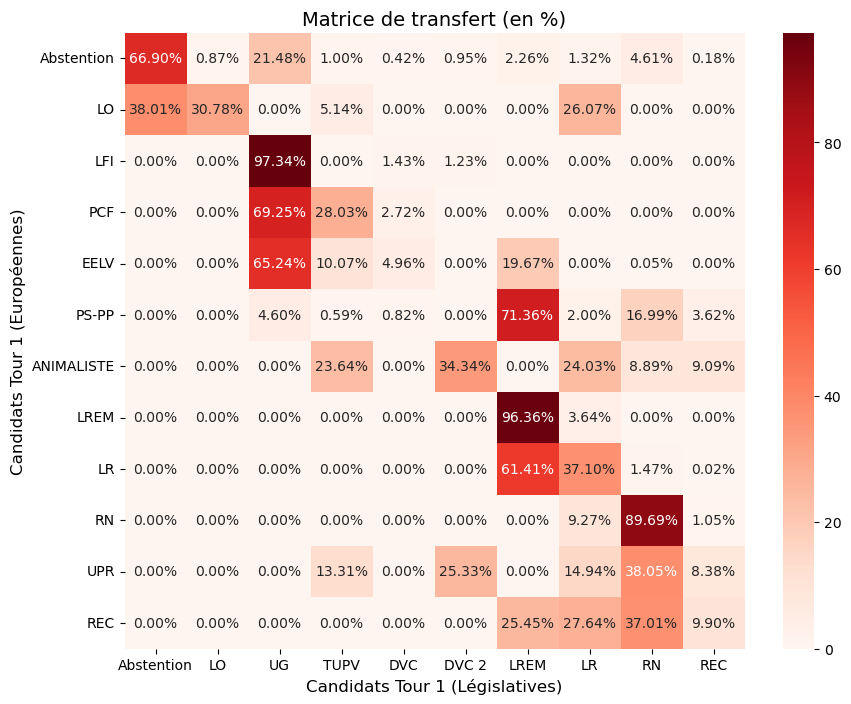

In [57]:
X = final_df[['% Abstention_Euro',  '% VINSC_LO_Euro', '% VINSC_LFI_Euro', '% VINSC_PCF_Euro', '% VINSC_EELV_Euro',  '% VINSC_PP_Euro', 
        '% VINSC_ANIM_Euro', '% VINSC_LREM_Euro',  '% VINSC_LR_Euro', 
        '% VINSC_RN_Euro',  '% VINSC_UPR_Euro', '% VINSC_REC_Euro']]
y = final_df[['% Abstentions_LegiT1', '% VINSC_LO_LegiT1', '% VINSC_UG_LegiT1', '% VINSC_TUPV_LegiT1','% VINSC_DVC_LegiT1', '% VINSC_DVC2_LegiT1', '% VINSC_LREM_LegiT1', '% VINSC_LR_LegiT1',
              '% VINSC_RN_LegiT1', '% VINSC_REC_LegiT1']]

for col in X.columns:
    X[col] = X[col]/100

for col in y.columns:
    y[col] = y[col]/100


T = ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6)

plot_transfer_matrix(T)